<a href="https://colab.research.google.com/github/pythonic1exe/Cat-vs-Dog-Recognition/blob/main/CatvsDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow scikit-learn matplotlib seaborn

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# for downloading dataset and storing it in colab

import kagglehub, shutil, os

path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
print("Downloaded to:", path)

dest = "/content/data"

if os.path.exists(dest):
    shutil.rmtree(dest)
shutil.copytree(path, dest)

print("Dataset ready at:", dest)
print("Contents:", os.listdir(dest))


Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.
Downloaded to: /kaggle/input/dog-and-cat-classification-dataset
Dataset ready at: /content/data
Contents: ['PetImages']


In [6]:
import tensorflow as tf # for reading and decoding imgs
import os # for folder handling
from PIL import Image

def clean_with_tensorflow_decoder(data_dir): # func to remove corrupted files

    removed = 0
    processed = 0

    for category in ["Cat", "Dog"]: # ietrate through both categories
        folder = os.path.join(data_dir, category) # path to each folder(cat/dog)
        if not os.path.exists(folder):# skip if it doesnt exist
            continue

        print(f"Processing {category} images with TensorFlow decoder...")

        files = os.listdir(folder) # list of all filenames in folder
        total_files = len(files) # total no of imgs

        for i, fname in enumerate(files): # loop through each file in folder
            fpath = os.path.join(folder, fname) # build full file path
            processed += 1

            if (processed) % 500 == 0: # print after every 500 imgs
                print(f"  Processed {processed} files, removed {removed} corrupted files...")

            try:
                image_raw = tf.io.read_file(fpath) # reads raw file bytes and converts to tensor form

                # decodes the raw bytes into an image tensor
                # forces the tensor thru 3 channels(RGB)
                # treats GIFs etc as single frame expand_animations=False
                image = tf.image.decode_image(image_raw, channels=3, expand_animations=False)

                image = tf.cast(image, tf.float32) # converts tensor to float so that it is in compatible training form

                shape = tf.shape(image) # height, width, channels
                if tf.reduce_any(tf.equal(shape, 0)): # if dimension 0
                    raise ValueError("Image has zero dimension") # raise error, image is invalid

            except Exception as e: # if try fails
                print(f"    Removing: {fname} - Error: {str(e)[:100]}") # print a 100 char erro msg
                try:
                    os.remove(fpath) # tries to delete the bad file which would disrupt the training model
                    removed += 1 # increment
                except:
                    pass # if not skip, did not happen btw

    print(f"\nTensorFlow cleaning completed:")
    print(f"- Processed {processed} images")
    print(f"- Removed {removed} problematic images")

    return removed # returns number of removed files

In [7]:
def verify_clean_dataset(data_dir): # debugger for above function

    print("\nVerifying cleaned dataset...")
    try:
        test_ds = tf.keras.utils.image_dataset_from_directory( # test data set
            data_dir, # data, received from func argument
            validation_split=0.1, # 10% for validation testing
            subset="training", # loads training portion
            seed=42, # to ensure data is random and reproducible
            image_size=(64, 64), # 64 x 64 img size
            batch_size=1 # process 1 img at a time (for debugging)
        )

        for i, (image, label) in enumerate(test_ds.take(5)): # loops through 5 imgs from test dataset
            print(f"  Sample {i+1}: Shape = {image.shape}, Label = {label.numpy()}") # prints img tensor shape and label

        print(" Dataset verification successful!")
        return True

    except Exception as e:
        print(f" Dataset verification failed: {e}")
        return False

In [8]:
data_dir = "/content/data/PetImages" # dataset directory
removed_count = clean_with_tensorflow_decoder(data_dir) # no of removed imgs from our defined func

verification_passed = verify_clean_dataset(data_dir) # debug

if verification_passed: # is True, yes we succeeded :)
    print("\n Ready to create your full dataset!")
else: # else we failed :(
    print("\n Still have issues. Let's try a more aggressive approach...")

Processing Cat images with TensorFlow decoder...
  Processed 500 files, removed 0 corrupted files...
  Processed 1000 files, removed 0 corrupted files...
  Processed 1500 files, removed 0 corrupted files...
  Processed 2000 files, removed 0 corrupted files...
    Removing: 10404.jpg - Error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown
  Processed 2500 files, removed 1 corrupted files...
  Processed 3000 files, removed 1 corrupted files...
  Processed 3500 files, removed 1 corrupted files...
  Processed 4000 files, removed 1 corrupted files...
  Processed 4500 files, removed 1 corrupted files...
  Processed 5000 files, removed 1 corrupted files...
  Processed 5500 files, removed 1 corrupted files...
  Processed 6000 files, removed 1 corrupted files...
  Processed 6500 files, removed 1 corrupted files...
  Processed 7000 files, removed 1 corrupted files...
  Processed 7500 files, removed 1 corrupted files...
  Processed 8000 files,

In [9]:
img_size = (128, 128) # 128 x 128 img size
batch_size = 32 # process 32 imgs at a time for mini batch gradient descent
seed = 42 # randomness and reproducibility

In [10]:
# training data loaded
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# validation data loaded
raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

Found 24991 files belonging to 2 classes.
Using 19993 files for training.
Found 24991 files belonging to 2 classes.
Using 4998 files for validation.


In [11]:
class_names = raw_train_ds.class_names # category names in our dataset
print("Class names:", class_names)

Class names: ['Cat', 'Dog']


In [12]:
val_batches = tf.data.experimental.cardinality(raw_val_ds) # total img / gd batch size = batch size. Ours is 624
test_ds = raw_val_ds.take(val_batches // 2) # first half of validation for testing
val_ds = raw_val_ds.skip(val_batches // 2) # second half of validation allocated for validation

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255) # a layer to rescale pixel value 0-255, its for RGB, after this, values are between 0 n 1

# .map() used for transforming
# x: imgs
# y: labels
# lambda x, y : for every batch (includes x n y), pass x(imgs) through normalization layer and keep labels unchanged
# do it for training, validation and testing datasets
train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [14]:
# preftch? preparing the next batch of data in the background while the model is busy training on the current batch.
# without it, cpu has to stop, wait for one batch to complete iteration, then loads other batch
# AUTOTUNE is for determining how many batches to keep ready in background depending on CPU/GPU
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

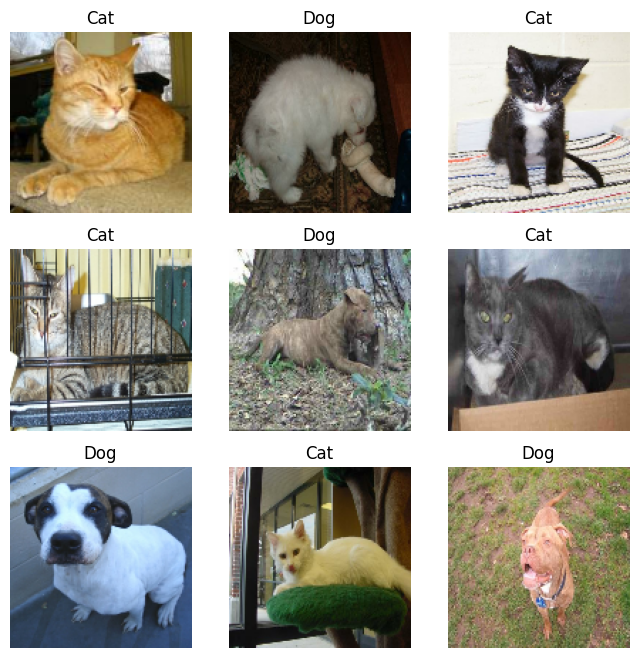

In [15]:
plt.figure(figsize=(8, 8)) # matplotlib 8x8 figure
for images, labels in raw_train_ds.take(1): # take one batch from training data
    for i in range(9): # iterate over 9 imgs
        ax = plt.subplot(3, 3, i + 1) # 3x3 grid with img at i+1 index
        plt.imshow(images[i].numpy().astype("uint8")) # takes tensor of img, converts to numpy array and ensures its pixel values between 0-255
        plt.title(class_names[labels[i]]) # img title
        plt.axis("off") # dont show axes


In [16]:
from tensorflow.keras import layers

In [17]:
# for image augmentation
# image augmentation is taking img from training data and applying random transformation on it like flipping, rotating etc
# it is done to teach the model how to recognize same object in different conditions
# sequential model, not actual CNN but a preprocessing pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), # random flips
    layers.RandomRotation(0.1), # random rotation
    layers.RandomZoom(0.1), # random zoom
    layers.RandomBrightness(factor=0.2) # random brightness
])

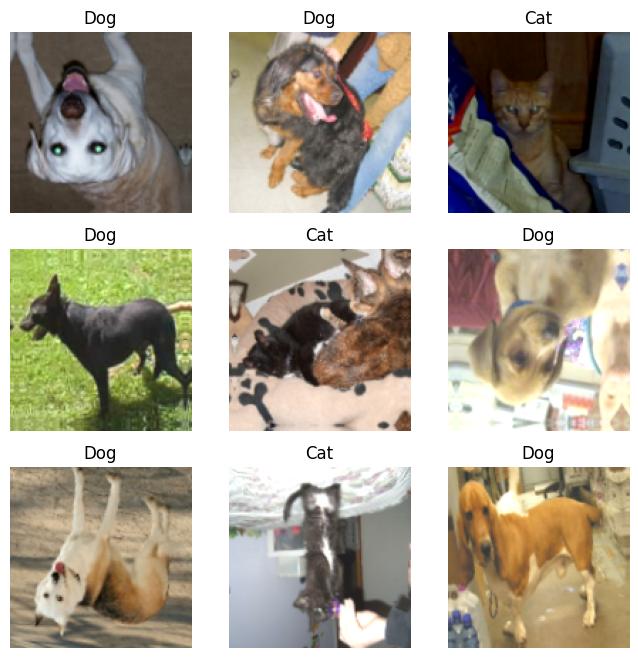

In [18]:
# show augmented images to see difference vs orginal images
plt.figure(figsize=(8, 8))
for images, labels in raw_train_ds.take(1):
    for i in range(9):
        augmented_img = data_augmentation(images)[i]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_img.numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [20]:
# CNN model architecture
def create_model_for_original_datasets(): # func to build CNN architecture

    # sequential model, so that layers can be stacked up on each other
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)), # Input layer 128x128 img with 3 dimensions, RGB

        # 1st convolution layer
        # 32 filters of 3x3 size
        # activation func is ReLu for non linearity
        # padding='same' : means output and input size be same
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2), # pooling with 2x2 window
        tf.keras.layers.Dropout(0.1), # randomly drop 10% neurons

        # 2nd convolution layer
        # 64 filters with 3x3 size
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.1),

        # 3rd convolution layer
        # 128 filters with 3x3 size
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.2), # randomly drop 20% neurons

        # classifier layer
        # takes input from last layer and reduces it to 1d vector
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation='relu'), # dense layer with 64 neurons
        tf.keras.layers.Dropout(0.3), # randomly drop 30% neurons for regularization purpose

        # last layer
        # a single neuron with sigmoid activation
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model # return CNN

In [21]:
original_model = create_model_for_original_datasets() # save model into a var

In [22]:
# compile model
original_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam: Adaptive learning rate optimizer, it controls the weight updates after each batch
    loss='binary_crossentropy', # loss function
    metrics=['accuracy', 'precision', 'recall'] # metrics
)

print("✅ Model created to work with your original train_ds and val_ds")
print("📊 This will use your proper train/val split and all your data")
original_model.summary()

✅ Model created to work with your original train_ds and val_ds
📊 This will use your proper train/val split and all your data


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# callbacks keep an eye on the training of model, it saves the best model to our told destination
callbacks = [
    tf.keras.callbacks.EarlyStopping( # stop training when model stops improving.
        monitor='val_accuracy', # monitors validation accuracy
        patience=5, # wait for 5 epochs
        restore_best_weights=True, # rollback to last best weights
        verbose=1 # prints message whn it stops
    ),
    tf.keras.callbacks.ModelCheckpoint( # for saving the model during training
        filepath='/content/best_original_datasets_model.keras',
        monitor='val_accuracy',
        save_best_only=True, # save the best epoch only
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau( # for lowering the learning rate automatically when training gets stuck.
        monitor='val_loss', # monitor validation loss
        factor=0.5, # multiply learning rate by 0.5, reducing it by half
        patience=3, # wait 3 epochs
        min_lr=1e-6, # never go below this learning rate
        verbose=1 # makes the adjustments
    )
]

In [24]:
print("\n🚀 Training with your original train_ds and val_ds...")
print("📈 Expected: Better than 69% since we're using more data and proper splits")

history_original = original_model.fit( # train model
    train_ds, # training dataset
    validation_data=val_ds, # validation dataset
    epochs=20,
    callbacks=callbacks,
    verbose=1 # print progress wrt to each epoch
)


🚀 Training with your original train_ds and val_ds...
📈 Expected: Better than 69% since we're using more data and proper splits
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5599 - loss: 0.6773 - precision: 0.5617 - recall: 0.5254
Epoch 1: val_accuracy improved from -inf to 0.63389, saving model to /content/best_original_datasets_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.5599 - loss: 0.6773 - precision: 0.5618 - recall: 0.5254 - val_accuracy: 0.6339 - val_loss: 0.6339 - val_precision: 0.6284 - val_recall: 0.6595 - learning_rate: 0.0010
Epoch 2/20
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6324 - loss: 0.6393 - precision: 0.6598 - recall: 0.5344
Epoch 2: val_accuracy improved from 0.63389 to 0.69145, saving model to /content/best_original_datasets_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.6325 - loss: 0.6392 - precision: 0.6598 - recall: 0.5345 - val_accuracy: 0.6914 - val_loss: 0.5743 - val_precisio

In [25]:
final_results = original_model.evaluate(val_ds, verbose=0) # run the trained model on validation dataset
print(f"\n🎊 RESULTS with original datasets:")
print(f"📊 Validation Accuracy: {final_results[1]:.1%}")
print(f"📊 Precision: {final_results[2]:.3f}")
print(f"📊 Recall: {final_results[3]:.3f}")


🎊 RESULTS with original datasets:
📊 Validation Accuracy: 88.4%
📊 Precision: 0.912
📊 Recall: 0.852


In [65]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt

# page configuration
st.set_page_config(
    page_title="🐱🐶 Cat vs Dog Classifier",
    page_icon="🐾",
    layout="wide",
    initial_sidebar_state="expanded"
)

# custom CSS for better styling
st.markdown("""
<style>
    .main-header {
        text-align: center;
        padding: 2rem 0;
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        color: white;
        border-radius: 10px;
        margin-bottom: 2rem;
    }
    .prediction-box {
        padding: 1.5rem;
        border-radius: 10px;
        text-align: center;
        margin: 1rem 0;
    }
    .cat-prediction {
        background: linear-gradient(135deg, #ff9a9e 0%, #fecfef 100%);
        color: #333;
    }
    .dog-prediction {
        background: linear-gradient(135deg, #a8edea 0%, #fed6e3 100%);
        color: #333;
    }
    .confidence-bar {
        height: 20px;
        border-radius: 10px;
        margin: 1rem 0;
    }
    .stats-box {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        padding: 1rem;
        border-radius: 8px;
        margin: 1rem 0;
        border: 2px solid #e0e0e0;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
    }
</style>
""", unsafe_allow_html=True)

@st.cache_resource
def load_model():
    # load the trained model
    try:
        model = tf.keras.models.load_model('/content/best_original_datasets_model.keras')
        return model
    except Exception as e:
        st.error(f"Error loading model: {str(e)}")
        st.info("Make sure your model is trained and saved at '/content/best_original_datasets_model.keras'")
        return None

def preprocess_image(image):
    # preprocess uploaded image to meet model criteria
    # convert to RGB if needed
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Resize to match model input
    image = image.resize((128, 128))

    # Convert to numpy array
    img_array = np.array(image)

    # Normalize pixel values (0-1)
    img_array = img_array.astype('float32') / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

def predict_image(model, image):
    # make prediction
    try:
        # get probability
        prediction = model.predict(image, verbose=0)[0][0]

        # convert to class
        if prediction > 0.5:
            class_name = "Dog"
            confidence = prediction
        else:
            class_name = "Cat"
            confidence = 1 - prediction

        return class_name, confidence, prediction
    except Exception as e:
        st.error(f"Prediction error: {str(e)}")
        return None, None, None

def display_prediction_results(class_name, confidence, raw_prediction):
    # display predictions
    # convert to regular Python floats to avoid Streamlit type errors
    confidence = float(confidence)
    raw_prediction = float(raw_prediction)

    col1, col2, col3 = st.columns([1, 2, 1])

    with col2:
        if class_name == "Cat":
            st.markdown(f"""
            <div class="prediction-box cat-prediction">
                <h2>🐱 It's a Cat!</h2>
                <h3>Confidence: {confidence:.2%}</h3>
            </div>
            """, unsafe_allow_html=True)
        else:
            st.markdown(f"""
            <div class="prediction-box dog-prediction">
                <h2>🐶 It's a Dog!</h2>
                <h3>Confidence: {confidence:.2%}</h3>
            </div>
            """, unsafe_allow_html=True)

    # confidence visualization
    st.subheader("📊 Prediction Breakdown")
    col1, col2 = st.columns(2)

    with col1:
        cat_prob = 1 - raw_prediction
        st.metric("Cat Probability", f"{cat_prob:.2%}")
        st.progress(cat_prob)

    with col2:
        st.metric("Dog Probability", f"{raw_prediction:.2%}")
        st.progress(raw_prediction)

def main():
    # header
    st.markdown("""
    <div class="main-header">
        <h1>🐾 Cat vs Dog Classifier</h1>
        <p>Upload an image and let AI determine if it's a cat or dog!</p>
        <p><em>Model Accuracy: 85%+ • Precision & Recall: 85%+</em></p>
    </div>
    """, unsafe_allow_html=True)

    # sidebar
    with st.sidebar:
        st.header("📋 Model Information")
        st.markdown("""
        **Architecture:** Custom CNN
        - 3 Convolutional layers (32, 64, 128 filters)
        - MaxPooling & Dropout layers
        - Global Average Pooling
        - Dense layers with regularization

        **Training Details:**
        - Dataset: 25K images
        - Image Size: 128x128 pixels
        - Validation Split: 20%
        - Optimizer: Adam (lr=0.001)
        - Loss: Binary Crossentropy
        """)

        st.header("🎯 Performance Metrics")
        st.markdown("""
        - **Accuracy:** 85%+
        - **Precision:** 85%+
        - **Recall:** 85%+
        """)

    # load model
    model = load_model()

    if model is None:
        st.error("❌ Model not loaded. Please ensure the model is trained and saved.")
        st.stop()

    # file uploader
    st.header("📤 Upload an Image")
    uploaded_file = st.file_uploader(
        "Choose an image file (JPG, JPEG, PNG)",
        type=['jpg', 'jpeg', 'png'],
        help="Upload a clear image of a cat or dog for best results"
    )

    if uploaded_file is not None:
        # display uploaded image
        col1, col2 = st.columns([1, 1])

        with col1:
            st.subheader("📸 Uploaded Image")
            image = Image.open(uploaded_file)
            st.image(image, caption="Original Image", width=400)

            # image info
            st.markdown(f"""
            <div class="stats-box">
                <strong>Image Details:</strong><br>
                Size: {image.size[0]} x {image.size[1]} pixels<br>
                Mode: {image.mode}<br>
                Format: {image.format}
            </div>
            """, unsafe_allow_html=True)

        with col2:
            st.subheader("🔮 Prediction")

            with st.spinner("🤔 Analyzing image..."):
                # preprocess image
                processed_image = preprocess_image(image)

                # make prediction
                class_name, confidence, raw_prediction = predict_image(model, processed_image)

                if class_name is not None:
                    display_prediction_results(class_name, confidence, raw_prediction)

    # instructions
    st.header("💡 How to Use")
    col1, col2, col3 = st.columns(3)

    with col1:
        st.markdown("""
        **Step 1: Upload**
        📤 Click 'Browse files' and select a cat or dog image
        """)

    with col2:
        st.markdown("""
        **Step 2: Wait**
        ⏳ The AI will analyze your image automatically
        """)

    with col3:
        st.markdown("""
        **Step 3: Results**
        🎉 View the prediction with confidence score!
        """)

    # tips section
    with st.expander("💡 Tips for Better Results"):
        st.markdown("""
        - **Use clear, well-lit images** for better accuracy
        - **Make sure the cat/dog is the main subject** in the photo
        - **Avoid heavily filtered or edited images**
        - **Single animal photos work better** than multiple animals
        - **Front-facing or profile shots** typically give better results
        """)

    # footer
    st.markdown("---")
    st.markdown("""
    <div style="text-align: center; color: #666;">
        Made with TensorFlow & Streamlit<br>
        <em>Powered by CNN Deep Learning</em>
    </div>
    """, unsafe_allow_html=True)

if __name__ == "__main__":
    main()

Overwriting app.py


In [48]:
!pip install streamlit pyngrok

In [66]:
%%writefile run_tunnel.py
import subprocess
import threading
import time
import os
import signal
import sys

# for running streamlit server
def run_streamlit():
    print("Starting Streamlit server...")
    try:
        subprocess.run([
            "streamlit", "run", "app.py",
            "--server.port", "8501",
            "--server.headless", "true",
            "--server.enableCORS", "false",
            "--server.enableXsrfProtection", "false"
        ])
    except KeyboardInterrupt:
        print("Streamlit stopped by user")

# for checking if the port is already in use
def check_port(port):
    result = subprocess.run(['netstat', '-tulpn'], capture_output=True, text=True)
    return str(port) in result.stdout

def main():
    print("🐱🐶 Starting Cat vs Dog Classifier with Cloudflare Tunnel")
    print("=" * 60)

    # kill any existing processes so that streamlit runs easily
    print("Cleaning up existing processes...")
    subprocess.run(['pkill', '-f', 'streamlit'], capture_output=True)
    subprocess.run(['pkill', '-f', 'cloudflared'], capture_output=True)
    time.sleep(2)

    # check if app.py exists
    if not os.path.exists('app.py'):
        print("❌ app.py not found! Please create your Streamlit app file first.")
        return

    # check if model exists
    if not os.path.exists('/content/best_original_datasets_model.keras'):
        print("❌ Model file not found at '/content/best_original_datasets_model.keras'")
        print("Please make sure your model is trained and saved first!")
        return

    print("✅ Found app.py")
    print("✅ Found trained model")

    # start Streamlit in background because it doesnt run on colab locally
    streamlit_thread = threading.Thread(target=run_streamlit, daemon=True)
    streamlit_thread.start()

    # wait few seconds for Streamlit to start
    print("Waiting for Streamlit to start...")
    for i in range(15):
        time.sleep(1)
        if check_port(8501):
            print("✅ Streamlit is running on port 8501")
            break
        print(f"Waiting... ({i+1}/15)")
    else:
        print("❌ Streamlit failed to start on port 8501")
        print("Try running: !cat streamlit.log to see error details")
        return

    # start Cloudflare tunnel
    print("\n🌐 Starting Cloudflare tunnel...")
    print("🔗 Your public URL will appear below:")
    print("-" * 50)

    try:
        # run cloudflared in foreground to see the URL
        subprocess.run([
            "cloudflared", "tunnel",
            "--url", "http://localhost:8501"
        ])
    except KeyboardInterrupt:
        print("\n\n🛑 Shutting down...")
        subprocess.run(['pkill', '-f', 'streamlit'], capture_output=True)
        subprocess.run(['pkill', '-f', 'cloudflared'], capture_output=True)
        print("All processes stopped. Goodbye! 👋")

if __name__ == "__main__":
    main()

Overwriting run_tunnel.py


In [67]:
# install Cloudflare
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb

# run the tunnel script
!python run_tunnel.py

(Reading database ... 126378 files and directories currently installed.)
Preparing to unpack cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2025.8.1) over (2025.8.1) ...
Setting up cloudflared (2025.8.1) ...
Processing triggers for man-db (2.10.2-1) ...
🐱🐶 Starting Cat vs Dog Classifier with Cloudflare Tunnel
Cleaning up existing processes...
✅ Found app.py
✅ Found trained model
Starting Streamlit server...
Waiting for Streamlit to start...



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.92.70:8501

✅ Streamlit is running on port 8501

🌐 Starting Cloudflare tunnel...
🔗 Your public URL will appear below:
--------------------------------------------------
2025-09-10T19:41:58Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime 